In [1]:
# pip install --upgrade xarray seaborn pandas numpy

In [3]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

### Download the dataset

In [4]:
from pathlib import Path
import requests
from tqdm import tqdm

def download_from_sciebo(public_url, to_filename, is_file=True):
    """
    Downloads a file or folder from a shared URL on Sciebo.
    """
    # Create the folder if a longer path was described
    path = Path(to_filename)
    if len(path.parts) > 1:
        Path(to_filename).parent.mkdir(parents=True, exist_ok=True)

    r = requests.get(public_url + "/download", stream=True)

    if 'Content-Length' in r.headers and is_file:
        total_size = int(r.headers['Content-Length'])
        progress_bar = tqdm(desc=f"Downloading {to_filename}", unit='B', unit_scale=True, total=total_size)
    else:
        progress_bar = None

    with open(to_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
            if progress_bar:
                progress_bar.update(len(chunk))

    if progress_bar:
        progress_bar.close()

download_from_sciebo('https://uni-bonn.sciebo.de/s/JFeueaaWCTVhTZh', 'data/steinmetz_2016-12-14_Cori.nc')

# ERP Analysis With Pandas And Seaborn

---

## Overview

We will continue to use [Steinmetz et al, 2019 in Nature](https://www.nature.com/articles/s41586-019-1787-x) dataset. The experiment involved a mouse being presented with two gradients of varying intensities, and the mouse had to adjust a wheel to center the brighter gradient on the screen. While the mouse performed this task, Local Field Potential (LFP) across different brain areas was measured for 250 times in 2.5 seconds (measurements taken every 0.01 second). There are 364 trials for each brain area and each trial has 250 LFP measurements.


**Analysis goals**

In these exercises, we will analyze and visualize Local Field Potential data collected from different brain regions. We will use Pandas to aggregate and manipulate the data, enabling us to compare LFP signal patterns across these brain areas. Additionally, we will utilize Seaborn to create visualizations to present our results.

**Learning goals**
Our focus will be on exploring the capabilities of Seaborn, a statistical plotting package that works well with Pandas dataframes. We will specifically delve into line plots, which are valuable for visualizing time series data.

---

### Load dataset

In this section, we'll work with a dataset from a single session recording of Cori the mouse ('steinmetz_2016-12-14_Cori.nc'). 

Our primary objective is to read this data and convert it into a Pandas dataframe, which will serve as the foundation for the subsequent exercises.

**Load dataset and convert to Pandas dataframe:**

xr.load_dataset('file.nc')`: Loads 'file.nc' from a specified file path using the xarray library. It facilitates data manipulation and analysis of multi-dimensional arrays. </br>
dset.to_dataframe(): Converts the xarray dataset (dset) into a Pandas DataFrame (df) for easier data manipulation and analysis. </br>
df.reset_index(): resets the index of the DataFrame, turning the current index into a new column and creating a default integer index. </br>

**Example** Read 'steinmetz_2016-12-14_Cori.nc' data using `xarray` and see what's in there!

In [6]:
dset = xr.load_dataset('data/steinmetz_2016-12-14_Cori.nc')
dset

<xarray.Dataset>
Dimensions:             (trial: 364, time: 250, cell: 734,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 7, spike_id: 2446173)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 359 360 361 362 363 364
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 729 730 731 732 733 734
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'ACA' 'LS' ... 'SUB' 'VISp'
  * spike_id            (spike_id) int32 1 2 3 4 ... 2446171 2446172 2446173
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 100 0 100 0 50 0 0 ... 0 100 50 50 0 25 100
    contrast_right      (trial) int8 0 50 50 0 100 0 0 ... 25 100 25 25 50 0 100
    gocue               (trial) float64 1.027 0.8744 0.8252 ... nan nan nan
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 1.0 1.0 1.0 -1.0 ... nan nan nan nan
    feedback_time       (trial) float64 1.187 1.438 0.986 2.296 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... -0...
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... 0.0
    lfp                 (brain_area_lfp, trial, time) float64 -2.851 ... 5.571
    spike_time          (spike_id) float32 0.2676 2.308 0.8535 ... 2.189 2.399
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 734 734 734 734 734
    spike_trial         (spike_id) uint32 21 21 31 37 43 ... 364 364 364 364 364
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

Nice! It has many data variables including lfp. Let's look at an example on how to extract a data variable into a Pandas dataframe

**Example** Extract 'brain_area' data variable to Pandas dataframe and store it in ba variable

In [7]:
ba = dset['brain_area'].to_dataframe()
ba

brain_area
cell           
1           ACA
2           MOs
3           ACA
4            LS
5           MOs
...         ...
730         SUB
731          DG
732          DG
733        VISp
734          DG

[734 rows x 1 columns]

Hmm! It might be good to have a separate index instead of using cell as index

**Example** reset_index of ba and display first five rows of the data

In [8]:
ba = ba.reset_index()
ba.head(5)

cell brain_area
0     1        ACA
1     2        MOs
2     3        ACA
3     4         LS
4     5        MOs

Great! Now, let's do this to the data we are actually going to use for the exercises

Convert 'lfp' data to Pandas dataframe and store it in lfp variable

In [9]:
lfp = dset['lfp'].to_dataframe()
lfp

lfp
brain_area_lfp trial time           
ACA            1     0.01  -2.850794
                     0.02  -4.039683
                     0.03  -4.195238
                     0.04  -3.228571
                     0.05   0.460317
...                              ...
VISp           364   2.46   6.761410
                     2.47  11.952319
                     2.48  15.552319
                     2.49  16.043228
                     2.50   5.570501

[637000 rows x 1 columns]

Reset index of lfp and display first 5 rows

In [10]:
lfp = lfp.reset_index()
lfp.head(5)

brain_area_lfp  trial  time       lfp
0            ACA      1  0.01 -2.850794
1            ACA      1  0.02 -4.039683
2            ACA      1  0.03 -4.195238
3            ACA      1  0.04 -3.228571
4            ACA      1  0.05  0.460317

## Explore and Visualize LFP Data for VISp Area

What was the variation of LFP measured from VISp brain area? Seaborn combined with some data extraction from Pandas dataframe provides an easy way to visualize this. First we will learn how to extract trials only from VISp area. Then we will warm up to Seaborn and visualization by plotting measurements from only one trial. Finally in this section, we will plot all trials together


```python
# Pandas 
df[df["col_1"] == 'val_1'] # Filter and display rows from the DataFrame where 'col_1' equals 'val_1'. </br>
df[(df["col_1"] == 'val_1') & (df["col_2"] == number)] # Filter and display rows from the DataFrame where 'col_1' equals 'val_1' and 'col_2' equals a specified number. 

# Seaborn 
sns.lineplot(         #  Tells Seaborn that we want to plot a line plot
    data=df,          #  Dataframe variable (what data will this plot be made from?)
    x="column1",      #  Column to use for the x axis of the plot.
    y="column2",      #  Column to use for the y axis of the plot.
    hue="column3",    #  Column to use for splitting the data into different colors.
    ...               # ...more columns can be added, to make a richer and more complex plot!
)                   
```

**Example** extract only 'trial' column

In [24]:
lfp['trial']

0           1
1           1
2           1
3           1
4           1
         ... 
636995    364
636996    364
636997    364
636998    364
636999    364
Name: trial, Length: 637000, dtype: int32

Extract only 'brain_area_lfp' 

In [25]:
lfp['brain_area_lfp']

0          ACA
1          ACA
2          ACA
3          ACA
4          ACA
          ... 
636995    VISp
636996    VISp
636997    VISp
636998    VISp
636999    VISp
Name: brain_area_lfp, Length: 637000, dtype: object

**Example** Can we see what are the different brain areas?

In [26]:
lfp['brain_area_lfp'].unique()

array(['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp'], dtype=object)

There are 7 brain areas

**Example** Extract all rows where 'trial' == 5

In [27]:
lfp[lfp['trial'] == 5]

brain_area_lfp  trial  time        lfp
1000              ACA      5  0.01  13.496145
1001              ACA      5  0.02  22.851701
1002              ACA      5  0.03  24.296145
1003              ACA      5  0.04  27.840590
1004              ACA      5  0.05  29.162812
...               ...    ...   ...        ...
547245           VISp      5  2.46  -6.815213
547246           VISp      5  2.47 -12.951577
547247           VISp      5  2.48  -5.960668
547248           VISp      5  2.49  -6.260668
547249           VISp      5  2.50  -1.015213

[1750 rows x 4 columns]

Extract all rows where 'trial' == 1

In [28]:
lfp[lfp['trial'] == 1]

brain_area_lfp  trial  time        lfp
0                 ACA      1  0.01  -2.850794
1                 ACA      1  0.02  -4.039683
2                 ACA      1  0.03  -4.195238
3                 ACA      1  0.04  -3.228571
4                 ACA      1  0.05   0.460317
...               ...    ...   ...        ...
546245           VISp      1  2.46  10.591280
546246           VISp      1  2.47   5.900371
546247           VISp      1  2.48  10.945826
546248           VISp      1  2.49   5.782189
546249           VISp      1  2.50  14.464007

[1750 rows x 4 columns]

Extract all rows where 'brain_area_lfp' == 'VISp'

In [29]:
lfp[lfp['brain_area_lfp'] == 'VISp']

brain_area_lfp  trial  time        lfp
546000           VISp      1  0.01   1.127644
546001           VISp      1  0.02  -5.854174
546002           VISp      1  0.03  -7.717811
546003           VISp      1  0.04 -11.745083
546004           VISp      1  0.05  -1.735993
...               ...    ...   ...        ...
636995           VISp    364  2.46   6.761410
636996           VISp    364  2.47  11.952319
636997           VISp    364  2.48  15.552319
636998           VISp    364  2.49  16.043228
636999           VISp    364  2.50   5.570501

[91000 rows x 4 columns]

Great! Now let's combine the two column conditions together to extract all rows where 'trial' == 1 and 'brain_area_lfp' == 'VISp'

Hint: Use df[(df['col_1'] == value) & (df['col_2'] == value)] to combine the two conditions

In [30]:
visp_trial_1 = lfp[(lfp['trial'] == 1) & (lfp['brain_area_lfp'] == 'VISp')]
visp_trial_1

brain_area_lfp  trial  time        lfp
546000           VISp      1  0.01   1.127644
546001           VISp      1  0.02  -5.854174
546002           VISp      1  0.03  -7.717811
546003           VISp      1  0.04 -11.745083
546004           VISp      1  0.05  -1.735993
...               ...    ...   ...        ...
546245           VISp      1  2.46  10.591280
546246           VISp      1  2.47   5.900371
546247           VISp      1  2.48  10.945826
546248           VISp      1  2.49   5.782189
546249           VISp      1  2.50  14.464007

[250 rows x 4 columns]

**Example** Plot trial 1 LFP measurements from VISp brain area

<Axes: xlabel='time', ylabel='lfp'>

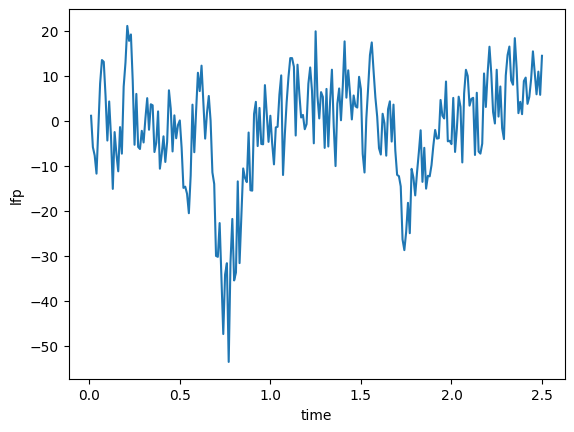

In [31]:
sns.lineplot(data=visp_trial_1, x='time', y='lfp')

Can you do the same for the second trial?

<Axes: xlabel='time', ylabel='lfp'>

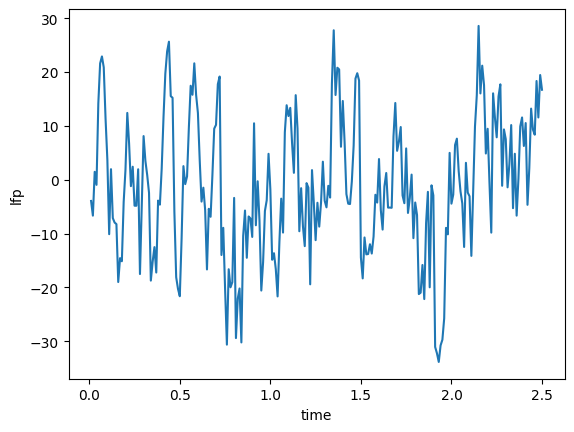

In [32]:
visp_trial_2 = lfp[(lfp['trial'] == 2) & (lfp['brain_area_lfp'] == 'VISp')]
sns.lineplot(data=visp_trial_2, x='time', y='lfp')

Good! One more for trial 3?

<Axes: xlabel='time', ylabel='lfp'>

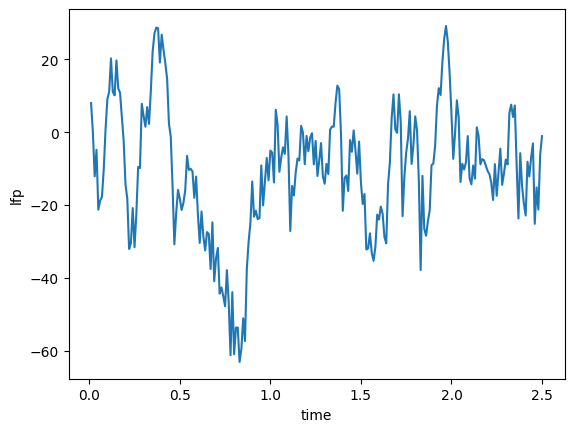

In [33]:
visp_trial_3 = lfp[(lfp['trial'] == 3) & (lfp['brain_area_lfp'] == 'VISp')]
sns.lineplot(data=visp_trial_3, x='time', y='lfp')

It will take a long time to plot all the trials individually? Is there a way to plot all trials in a single plot? 

Spoiler alert! Yes

Seaborn has a way of knowing that you want to plot each trial in different color by setting hue parameter.

sns.lineplot(data=, x=, y=, hue='trial')

**Example** Extract only VISp brain area and plot all trials in the same plot using hue='trial' 

<Axes: xlabel='time', ylabel='lfp'>

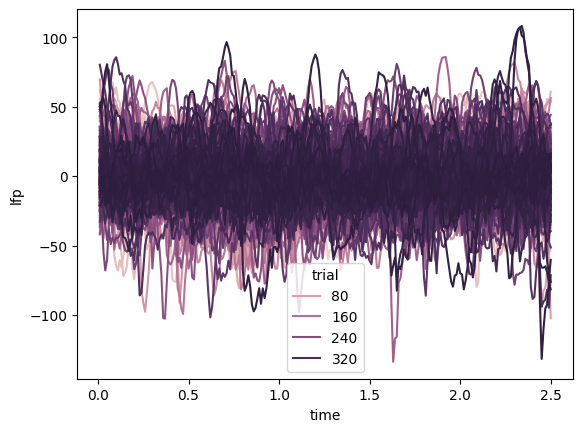

In [36]:
visp = lfp[lfp['brain_area_lfp'] == 'VISp']
sns.lineplot(data=visp, x='time', y='lfp', hue='trial')

Extract only ACA brain area and plot all trials in the same plot using hue='trial' 

<Axes: xlabel='time', ylabel='lfp'>

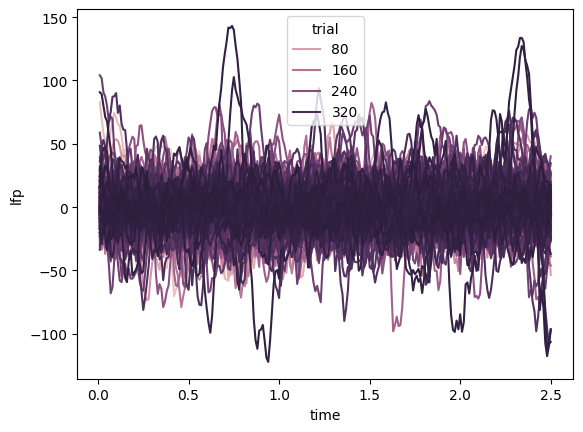

In [37]:
aca = lfp[lfp['brain_area_lfp'] == 'ACA']
sns.lineplot(data=aca, x='time', y='lfp', hue='trial')

Once more: Extract only SUB brain area and plot all trials in the same plot using hue='trial'

<Axes: xlabel='time', ylabel='lfp'>

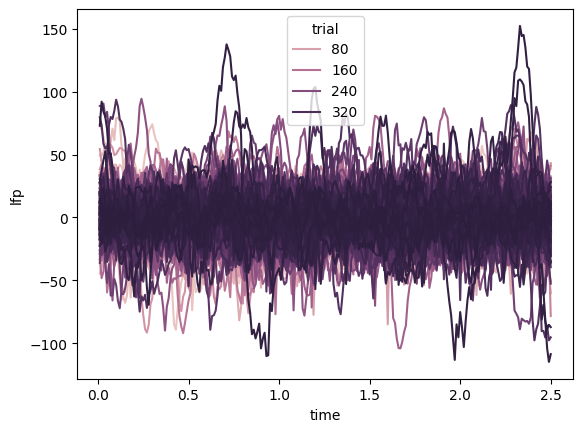

In [38]:
sub = lfp[lfp['brain_area_lfp'] == 'SUB']
sns.lineplot(data=sub, x='time', y='lfp', hue='trial')

The plot is over-crowded. It might be useful just to see mean variation in each time bin. Can we try to use statistical measures like mean to simplify this plot?

## Visualize LFP Data for VISp Area (mean/median of all trials in a time bin)

We will aggregate LFP for all trials and plotting a single line that represents the overall trend of 'lfp' values over time across all trials.

The following steps have to be performed for this
1. Group and aggregate the data such that there is only one measurement per time bin (mean LFP across all trials at a given time)
2. Estimate a range of values within which the aggregation metric (mean/median) is likely to fall with 90/95/99 percent confidence (Confidence Interval)
3. Plot the resulting time series
4. Also plot the confidence interval

Phew! Luckily, Seaborn can do all these for us in a single line of code

```python
sns.lineplot(         #  We want a line plot
    data=df,          #  Dataframe variable (what data will this plot be made from?)
    x="column1",      #  Column to use for the x axis of the plot.
    y="column2",      #  Column to use for the y axis of the plot.
    errorbar="ci",    #  Metric to display as errorbar/errorband.
    n_boot=number,    #  Number of bootstrap resampling to compute the confidence intervals.
)

sns.relplot(          #  We want a relational plot
    data=df,          #  Dataframe variable (what data will this plot be made from?)
    x="column1",      #  Column to use for the x axis of the plot.
    y="column2",      #  Column to use for the y axis of the plot.
    errorbar="ci",    #  Metric to display as errorbar/errorband.
    n_boot=number,    #  Number of bootstrap resampling to compute the confidence intervals.
    col="column3",    #  Different panels for each unique value in column3,
    kind="line",      #  We want to show a line plot. Other option is "scatter" for scatter plot.
    col_wrap=n,       #  New row of panel in figure after every n unique categories in "column3" (if 4 brain areas, there will be two rows and two columns of line plot)         
)

sns.relplot(data=lfp, x='time', y='lfp', col='brain_area_lfp', kind='line', errorbar='ci', n_boot=10)
```

**Example** Plot aggregate LFP values at each time bin along with error band representing the confidence interval

<Axes: xlabel='time', ylabel='lfp'>

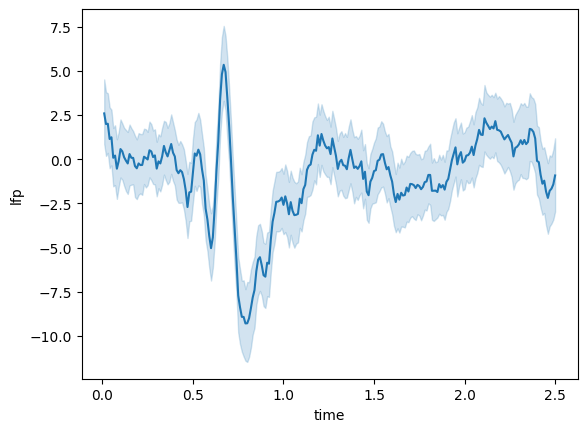

In [39]:
visp = lfp[lfp['brain_area_lfp'] == 'VISp']
sns.lineplot(data=visp, x='time', y='lfp', errorbar='ci')

That must have taken a while! The parameter `errorbar='ci'` specifies that confidence intervals should be added to the lineplot to indicate the uncertainty in the data. Seaborn will compute and add error bars to the plot to represent the confidence intervals for the data points. We can make this quicker by setting the parameter `n_boot` to a numerical value which sets the number of bootstrap resampling iterations used to compute the confidence intervals. 

Repeat the same plot but set n_boot=100

<Axes: xlabel='time', ylabel='lfp'>

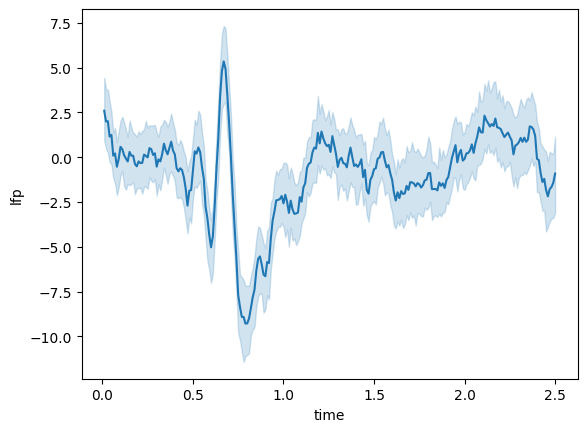

In [40]:
sns.lineplot(data=visp, x='time', y='lfp', errorbar='ci', n_boot=100)

Seaborn provides different ways to represent the uncertainty (errorbar) apart from 'ci'. 

Set errorbar='sd' to plot standard deviation instead of confidence intervals

<Axes: xlabel='time', ylabel='lfp'>

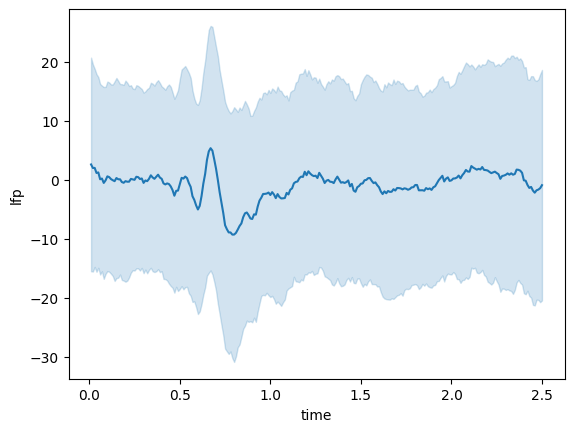

In [41]:
sns.lineplot(data=visp, x='time', y='lfp', errorbar='sd', n_boot=100)

Set errorbar='se' to plot standard error 

<Axes: xlabel='time', ylabel='lfp'>

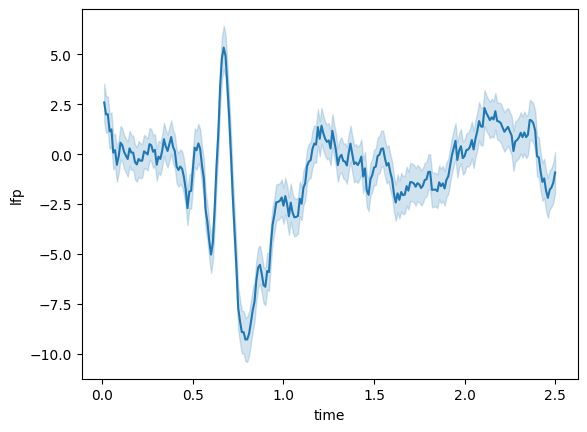

In [42]:
sns.lineplot(data=visp, x='time', y='lfp', errorbar='se', n_boot=100)

Let's do the same for ACA brain area

<Axes: xlabel='time', ylabel='lfp'>

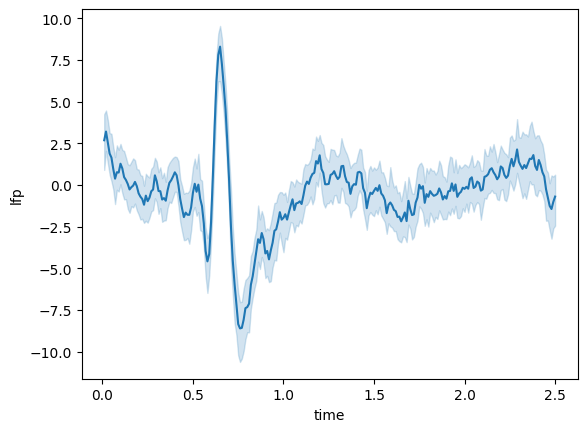

In [43]:
aca = lfp[lfp['brain_area_lfp'] == 'ACA']
sns.lineplot(data=aca, x='time', y='lfp', errorbar='ci', n_boot=100)

One more for LS 

<Axes: xlabel='time', ylabel='lfp'>

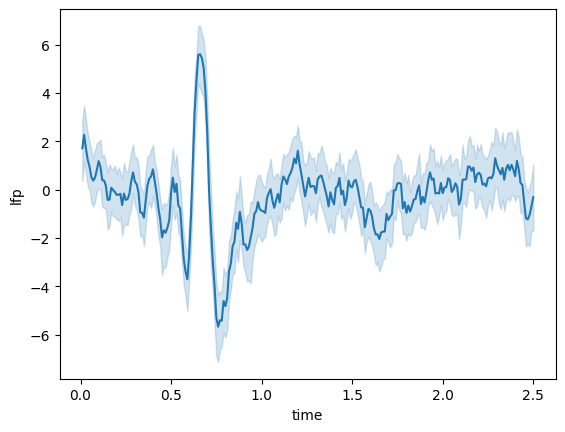

In [44]:
ls = lfp[lfp['brain_area_lfp'] == 'LS']
sns.lineplot(data=ls, x='time', y='lfp', errorbar='ci', n_boot=100)

You can even set confidence intervals. By default, it is 95%. We can set it to 99% (the chance of us being wrong about the mean lying within this range is 1%)

Set errorbar=('ci', 99)

<Axes: xlabel='time', ylabel='lfp'>

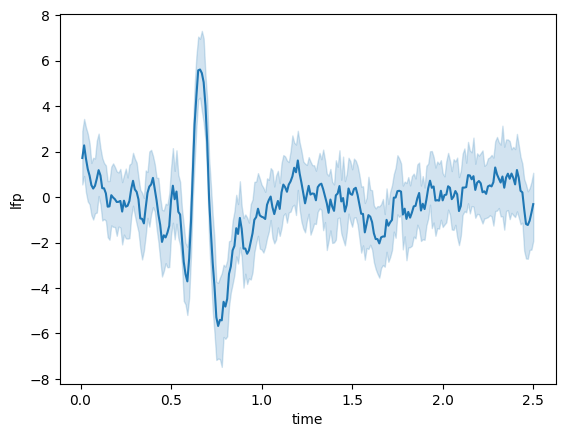

In [45]:
ls = lfp[lfp['brain_area_lfp'] == 'LS']
sns.lineplot(data=ls, x='time', y='lfp', errorbar=('ci', 99), n_boot=100)

Set 90% confidence interval

<Axes: xlabel='time', ylabel='lfp'>

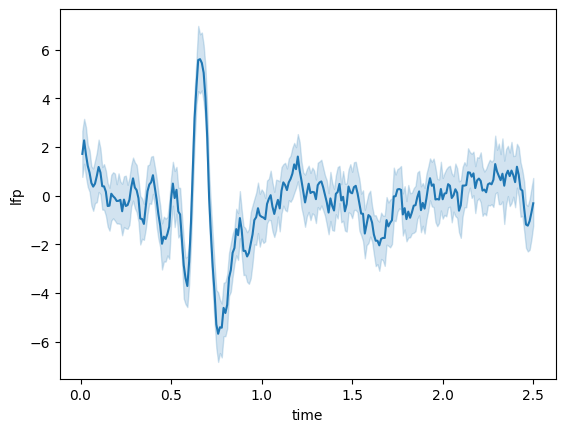

In [46]:
ls = lfp[lfp['brain_area_lfp'] == 'LS']
sns.lineplot(data=ls, x='time', y='lfp', errorbar=('ci', 90), n_boot=100)

You can also set different estimator instead of mean using `estimator` parameter. It takes in any of the Pandas method like 'mean', 'median', 'size', 'std' etc!

**Example** Use estimator='median' for 'LS' brain area

<Axes: xlabel='time', ylabel='lfp'>

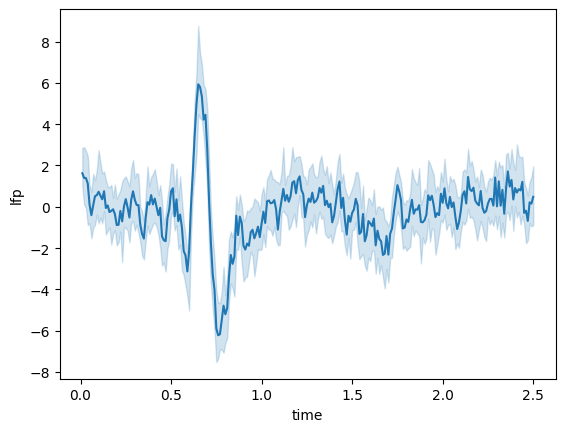

In [47]:
ls = lfp[lfp['brain_area_lfp'] == 'LS']
sns.lineplot(data=ls, x='time', y='lfp', estimator='median', errorbar='ci', n_boot=100)

Use estimator='median' for 'ACA' brain area

<Axes: xlabel='time', ylabel='lfp'>

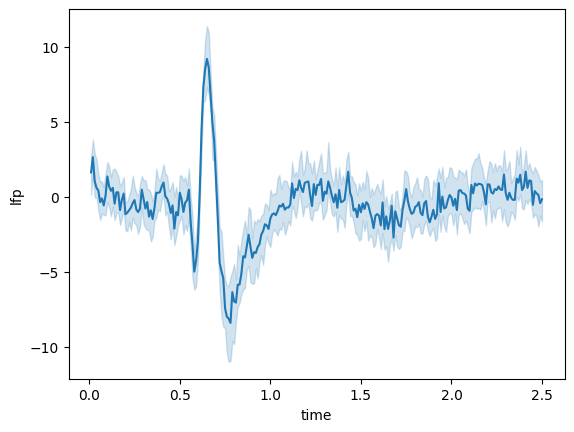

In [48]:
aca = lfp[lfp['brain_area_lfp'] == 'ACA']
sns.lineplot(data=aca, x='time', y='lfp', estimator='median', errorbar='ci', n_boot=100)

Just for the fun of it, use estimator='size' for 'ACA' brain area

<Axes: xlabel='time', ylabel='lfp'>

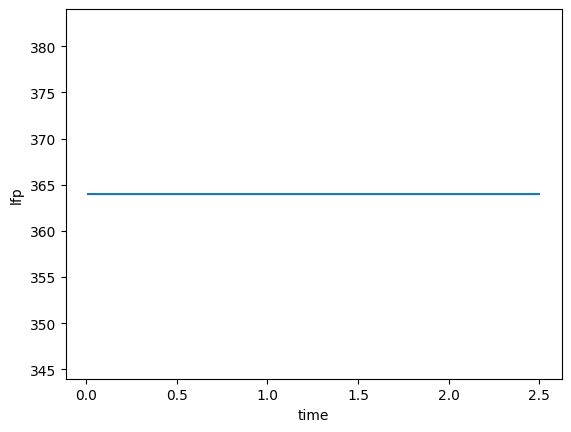

In [49]:
aca = lfp[lfp['brain_area_lfp'] == 'ACA']
sns.lineplot(data=aca, x='time', y='lfp', estimator='size', errorbar='ci', n_boot=100)

That's a funny plot where it shows that there are 364 values available at each time measurement. The choice of estimator depends on what you are interested in. Generally mean or median are enough to get meaningful information about the data!


We plotted each brain area separately. Wouldn't it be great if we can have this plot for all brain areas separated into different panels with a single line?

Seaborn has this capability with the help of relational plot or `relplot`.

Seaborn relational plot (relplot) with line plots for 'lfp' values over 'time', organized into separate columns for different 'brain_area_lfp', while including error bars based on bootstrapped confidence intervals (CI) computed from 10 resamples (n_boot=10).

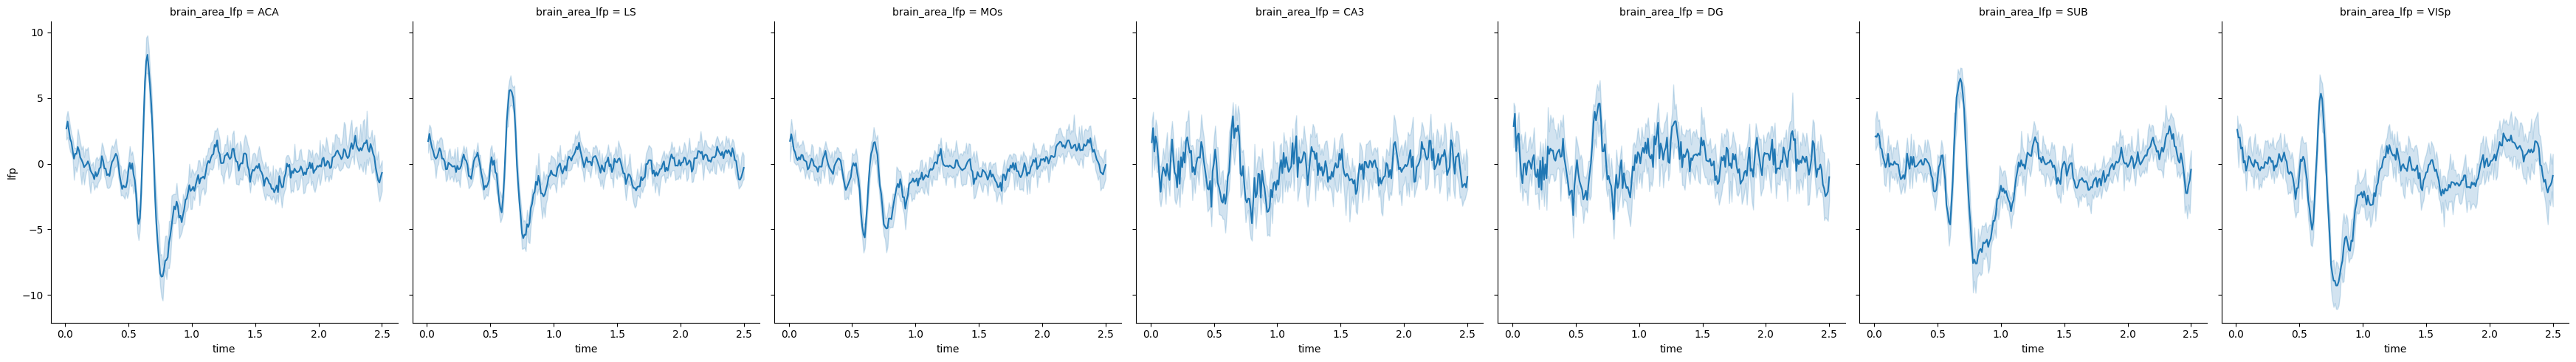

In [50]:
sns.relplot(data=lfp, x='time', y='lfp', col='brain_area_lfp', kind='line', errorbar='ci', n_boot=10)

That plot looks a bit too wide. Wouldn't it be nice to have only three columns? We can let relplot know this by using the argument `col_wrap=3`

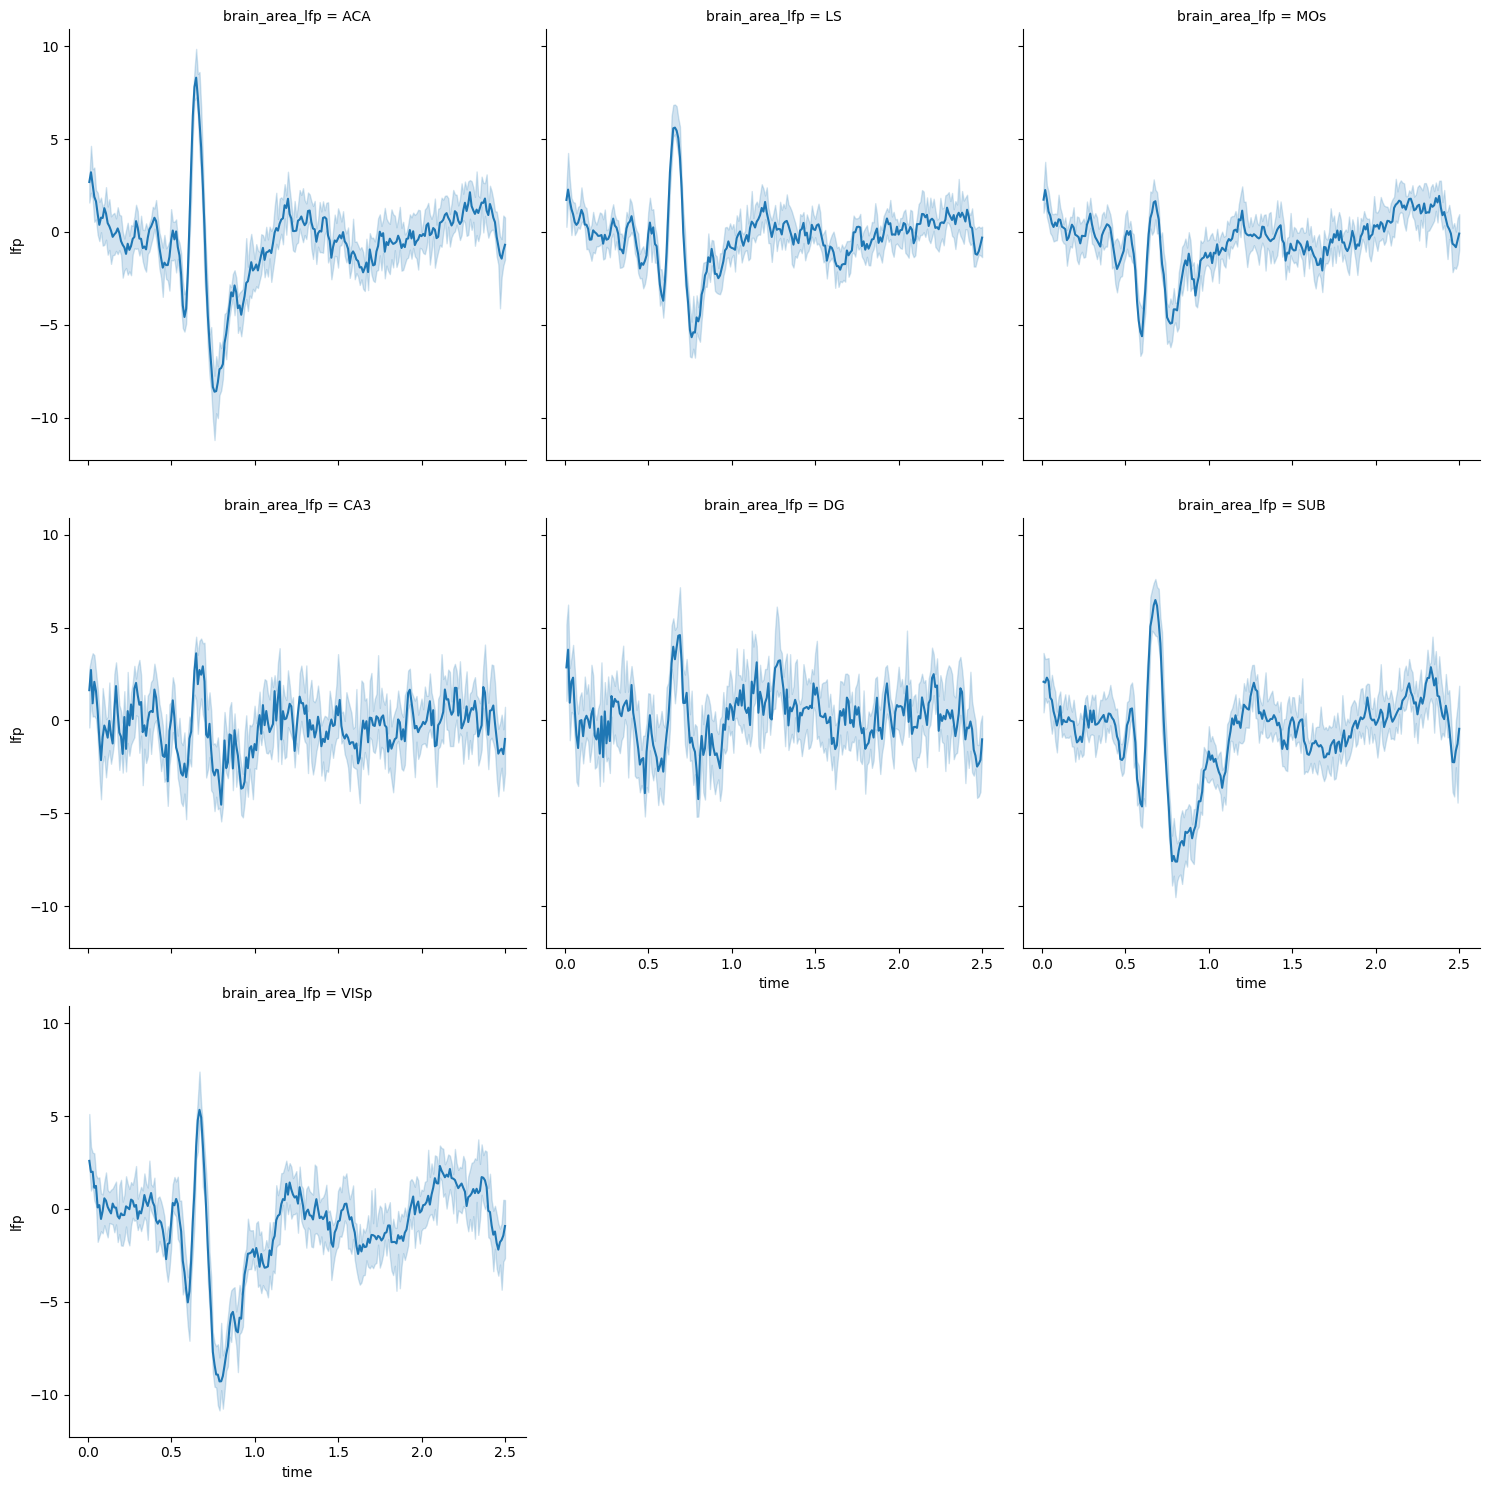

In [51]:
sns.relplot(data=lfp, x='time', y='lfp', col='brain_area_lfp', col_wrap=3, kind='line', errorbar='ci', n_boot=10)

Use estimator='median' to plot medians instead of means

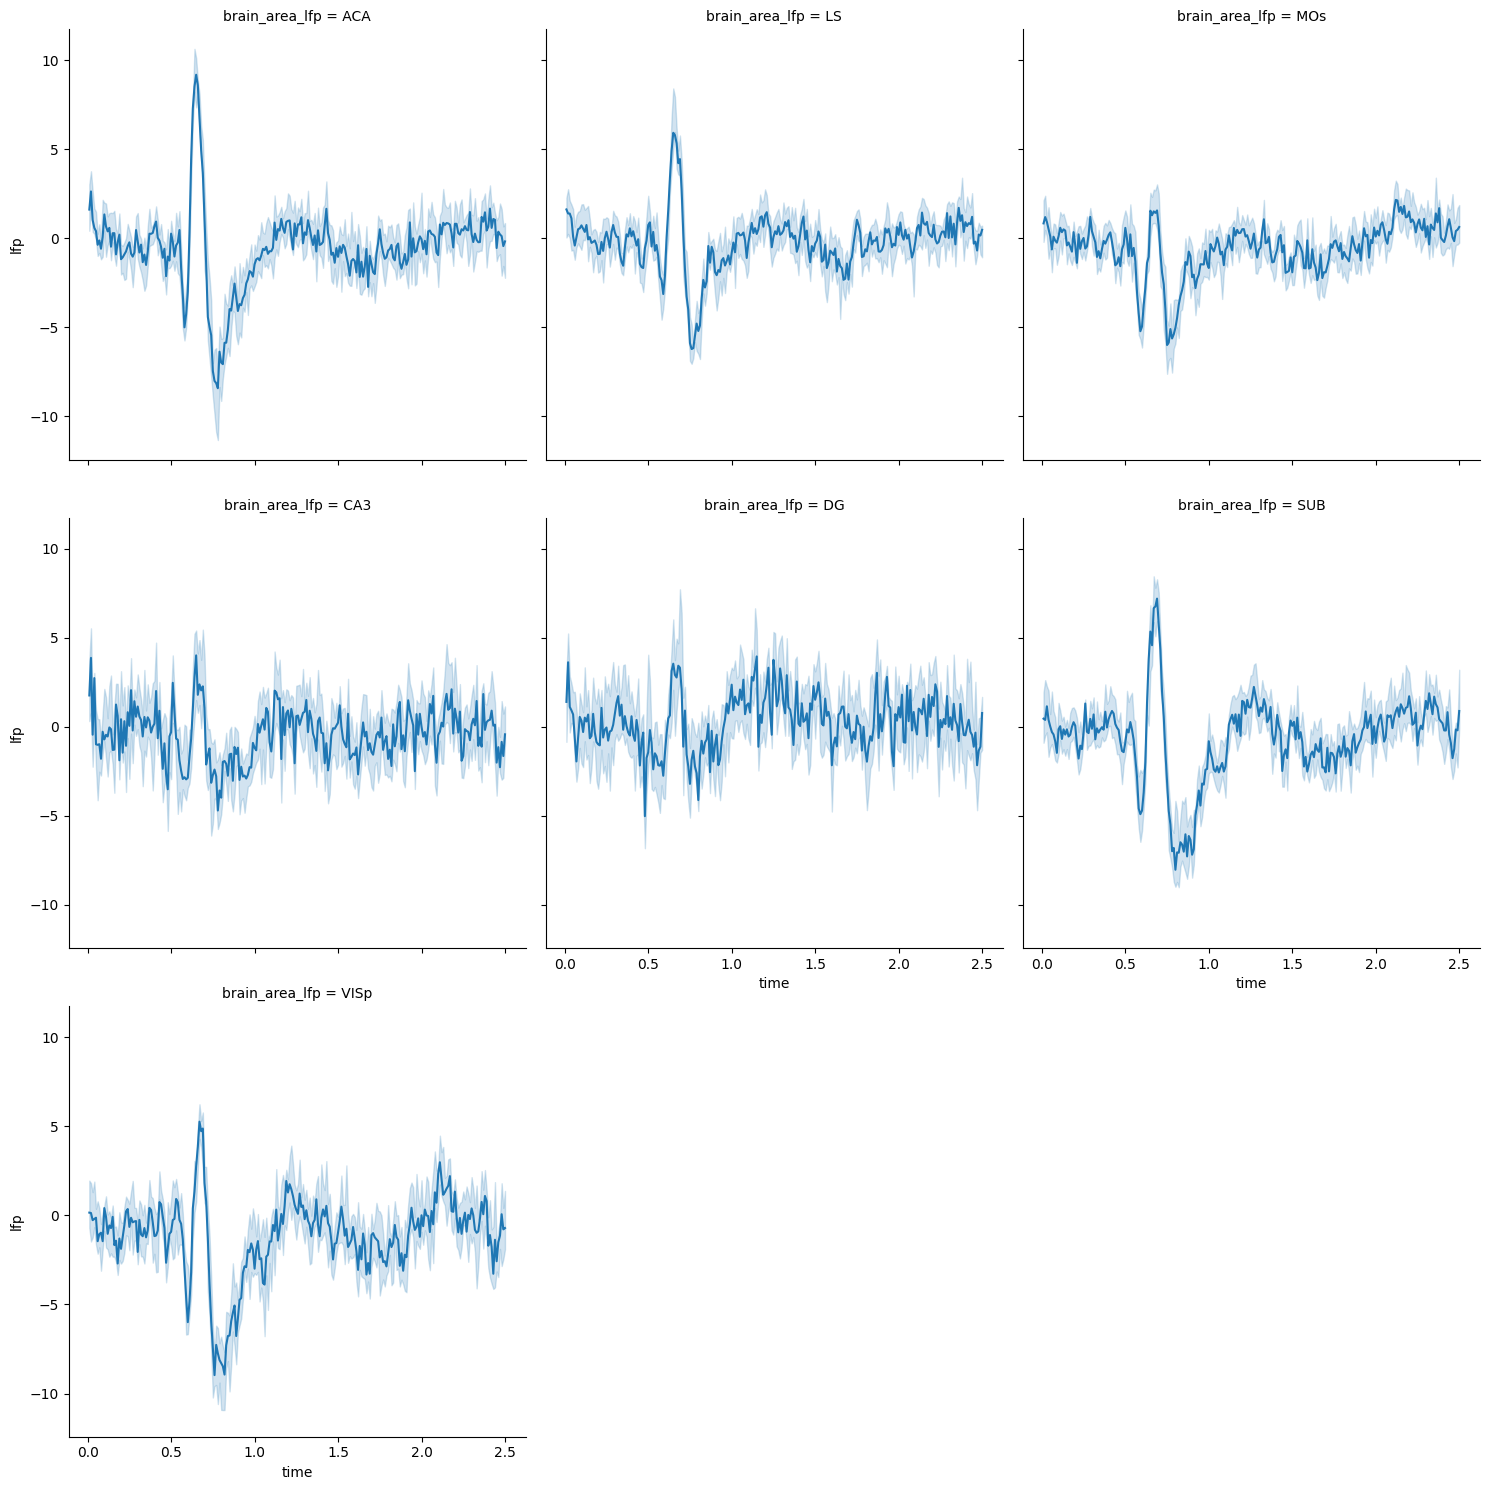

In [52]:
sns.relplot(data=lfp, x='time', y='lfp', col='brain_area_lfp', col_wrap=3, kind='line', estimator='median', errorbar='ci', n_boot=10)

Use estimator 'min'

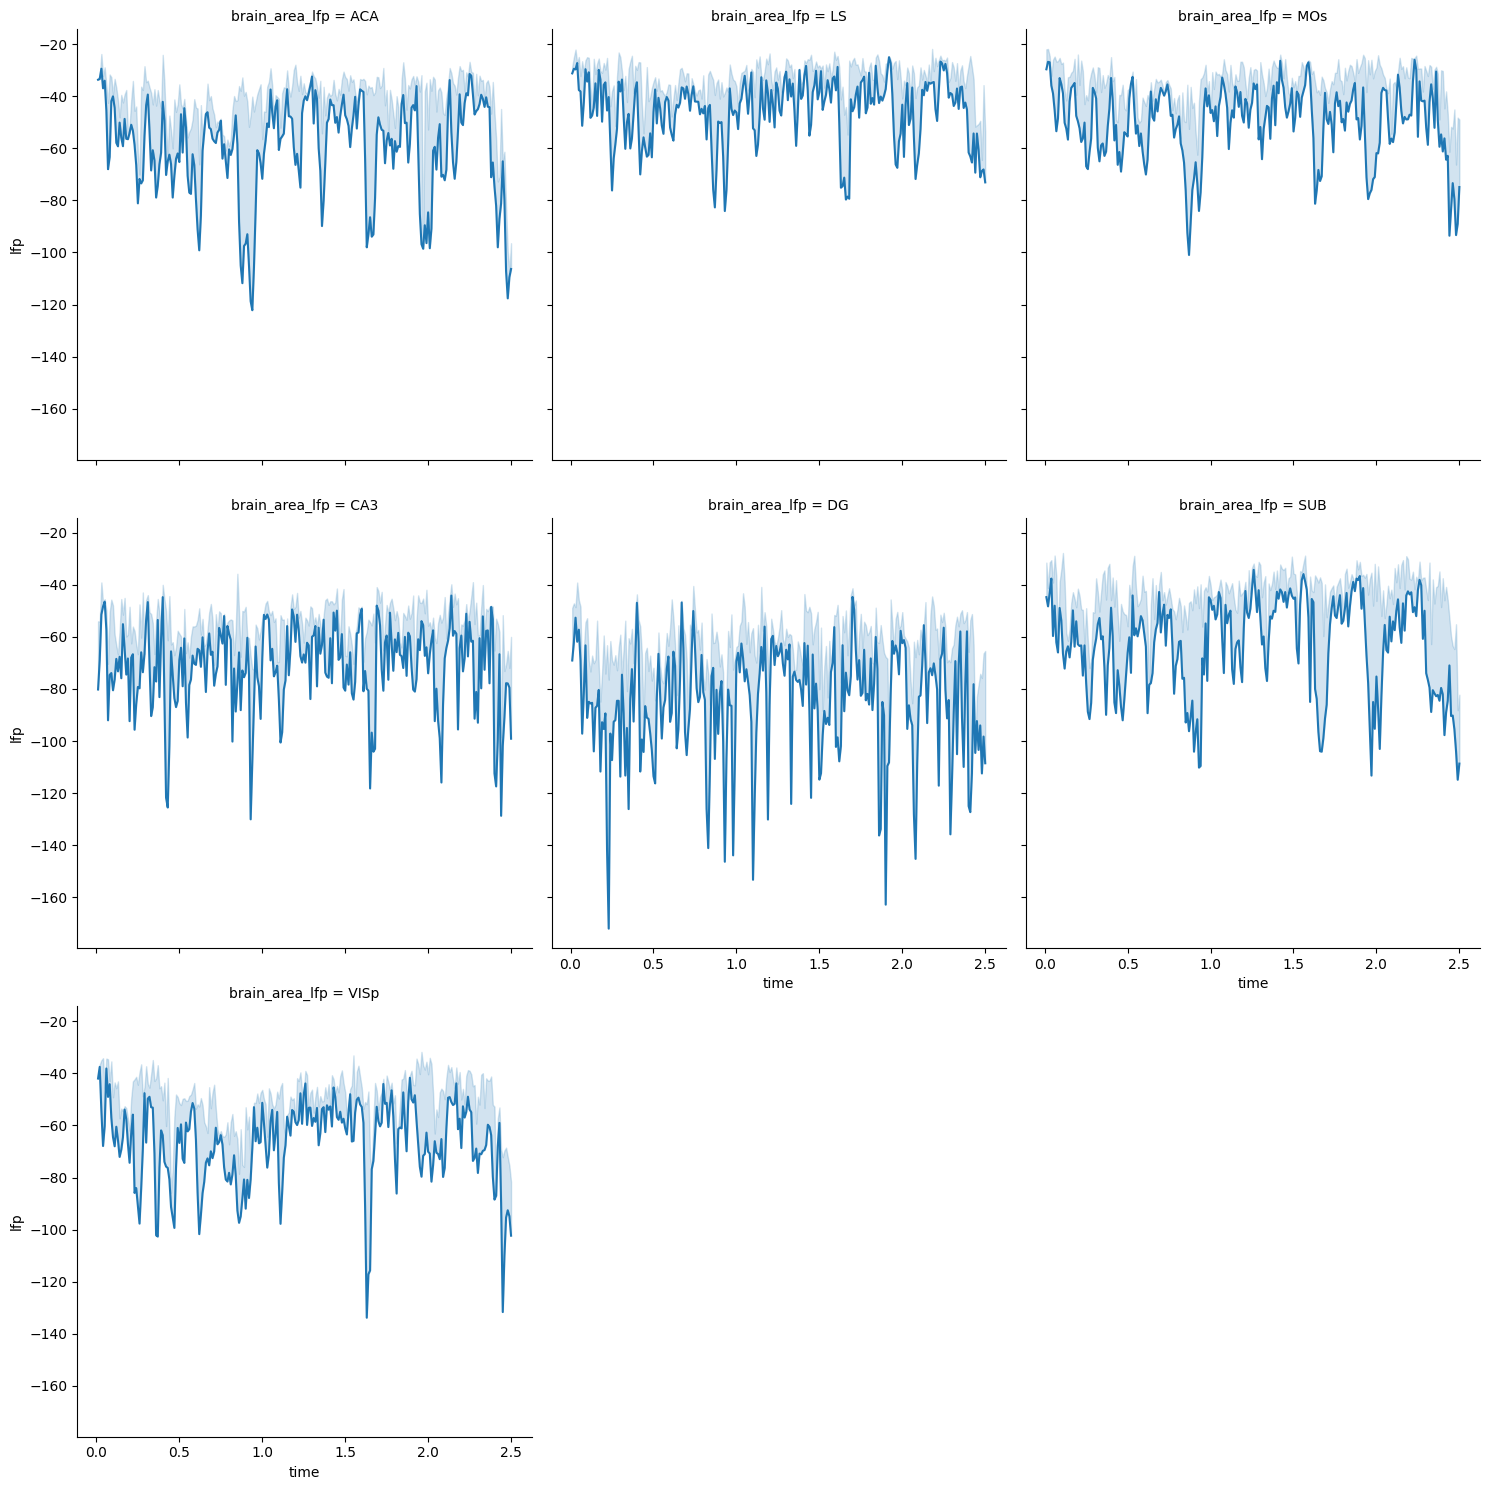

In [53]:
sns.relplot(data=lfp, x='time', y='lfp', col='brain_area_lfp', col_wrap=3, kind='line', estimator='min', errorbar='ci', n_boot=10)

For the sake of completion, use estimator='max'

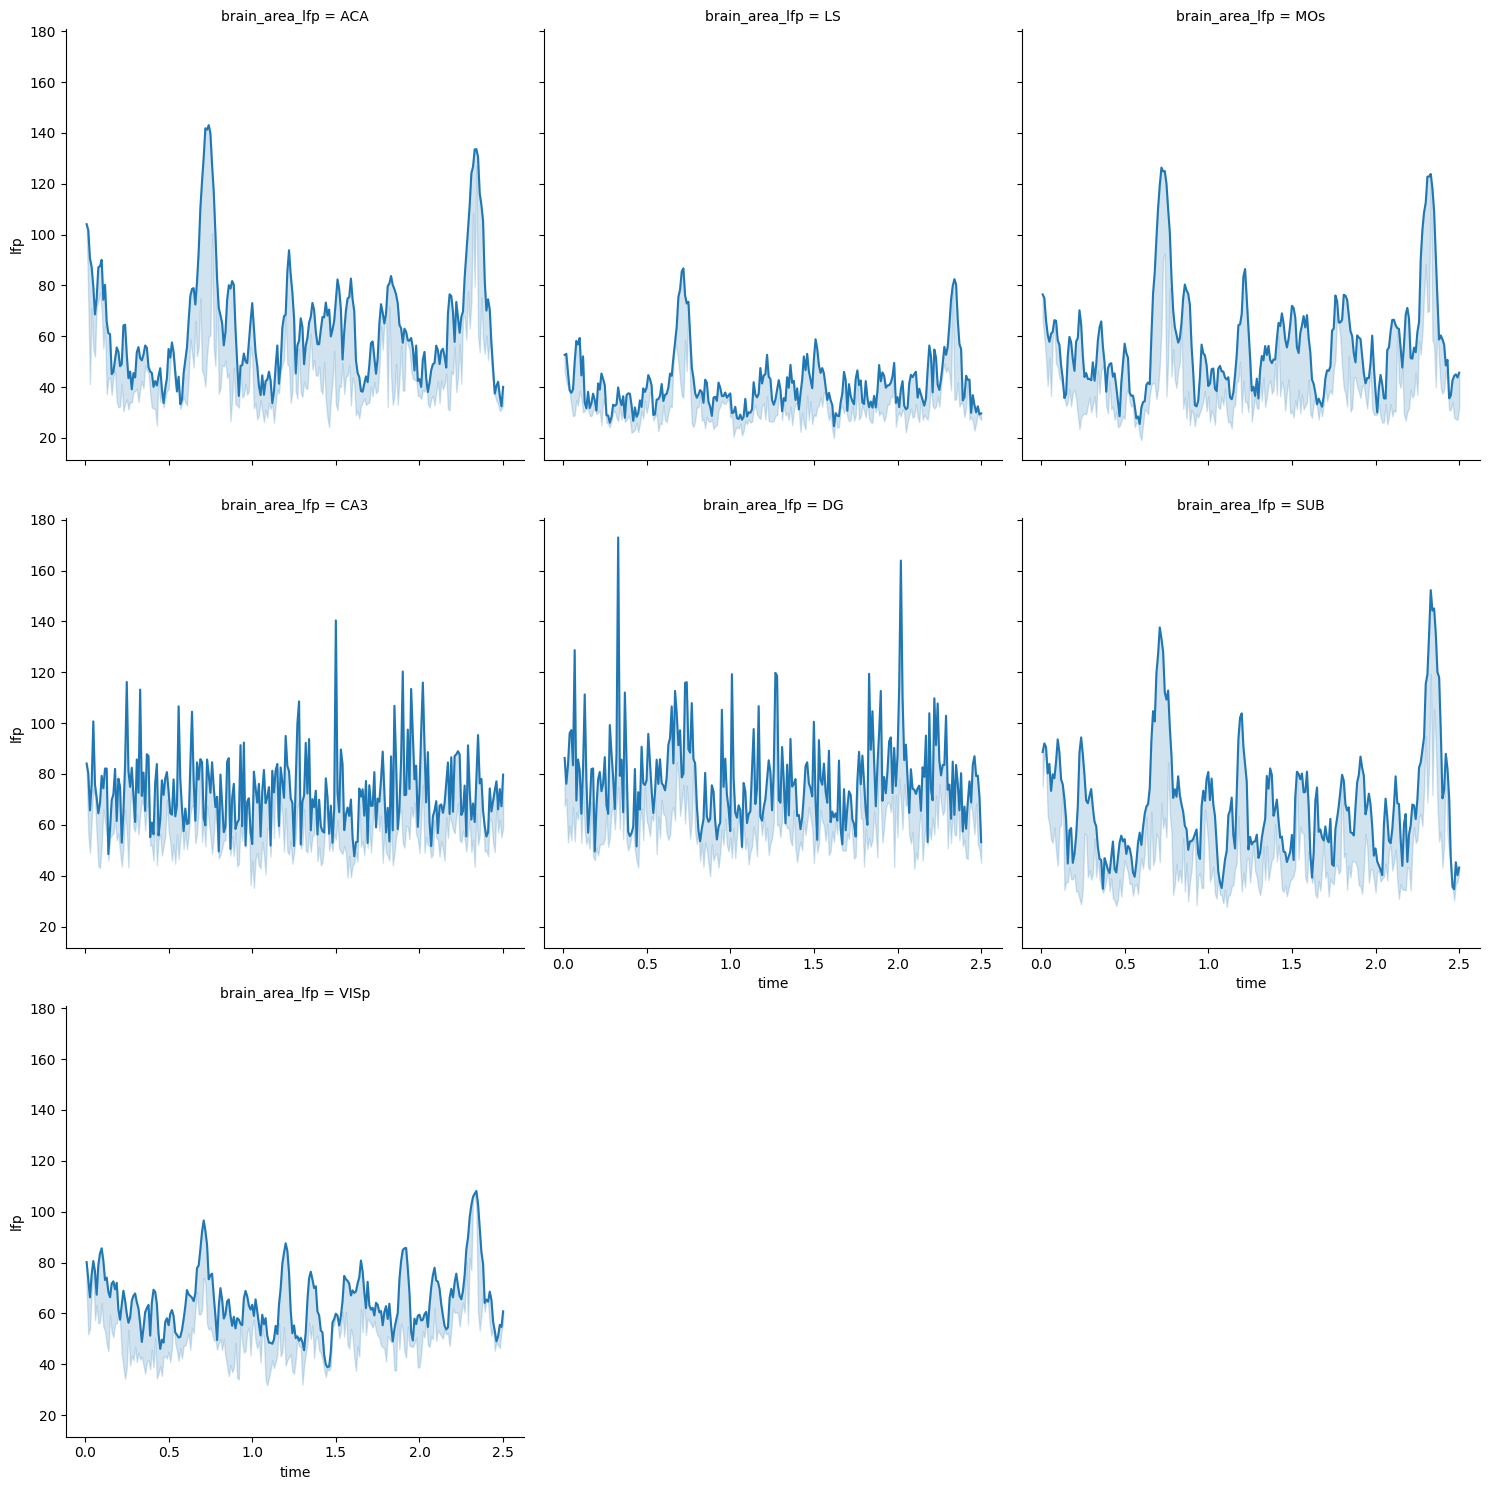

In [54]:
sns.relplot(data=lfp, x='time', y='lfp', col='brain_area_lfp', col_wrap=3, kind='line', estimator='max', errorbar='ci', n_boot=10)

## Visualizing Average LFP Data with Heatmap

Let's try to visualize same information for all brain area in a different format. Sometimes, it might be enough to only see variations in terms of color change rather than number. This case, heatmap could be very informative to identify patterns in the time series of mean LFP signal across all trials.

We will make use of group-by method of Pandas dataframe to aggregate LFP and Seaborn heatmap method to visualize

`sns.heatmap()`: Create a heatmap visualization to display the mean LFP data using a color gradient. </br>
`df.groupby()`: Aggregate colums with respect to a categorical valued column. </br>
`df.unstack()`: Convert multi-index dataframe to wide format table. </br>

**Example** Find mean lfp of each brain_area 

In [55]:
lfp.groupby('brain_area_lfp')['lfp'].mean()

brain_area_lfp
ACA    -0.514545
CA3    -0.330150
DG      0.186883
LS     -0.244636
MOs    -0.440104
SUB    -0.595160
VISp   -0.885078
Name: lfp, dtype: float64

Find mean lfp of each time

In [56]:
lfp.groupby('time')['lfp'].mean()

time
0.01    2.185657
0.02    2.613272
0.03    1.737390
0.04    1.663617
0.05    1.403416
          ...   
2.46   -1.527758
2.47   -1.618838
2.48   -1.494268
2.49   -1.259201
2.50   -0.640280
Name: lfp, Length: 250, dtype: float64

There are other aggregation methods too like median(), std() for standard deviation, min() for minimum, max() for maximum, etc

Find median LFP of each brain area

In [57]:
lfp.groupby('brain_area_lfp').median()

trial   time       lfp
brain_area_lfp                        
ACA             182.5  1.255 -0.479932
CA3             182.5  1.255 -0.426170
DG              182.5  1.255  0.299241
LS              182.5  1.255 -0.173639
MOs             182.5  1.255 -0.463571
SUB             182.5  1.255 -0.636395
VISp            182.5  1.255 -1.085343

Find minimum lfp of each brain_area

In [58]:
lfp.groupby('brain_area_lfp')['lfp'].min()

brain_area_lfp
ACA    -122.177778
CA3    -130.074430
DG     -172.058377
LS      -84.084014
MOs    -100.964490
SUB    -114.875510
VISp   -133.851206
Name: lfp, dtype: float64

Find maximum lfp of each brain_area

In [59]:
lfp.groupby('brain_area_lfp')['lfp'].max()

brain_area_lfp
ACA     143.055556
CA3     140.405762
DG      173.035358
LS       86.690986
MOs     126.365510
SUB     152.306463
VISp    108.156215
Name: lfp, dtype: float64

Find standard deviation of LFP in each brain area

In [60]:
lfp.groupby('brain_area_lfp')['lfp'].std()

brain_area_lfp
ACA     14.644016
CA3     19.595801
DG      21.019145
LS      11.689013
MOs     12.413976
SUB     15.402966
VISp    17.691439
Name: lfp, dtype: float64

**Example** Let's find mean lfp value of each trial of each brain area

In [61]:
lfp.groupby(['brain_area_lfp', 'trial'])['lfp'].mean()

brain_area_lfp  trial
ACA             1         0.677562
                2        -1.527103
                3        -4.225222
                4        -6.515680
                5         0.106590
                           ...    
VISp            360      -1.776045
                361      11.029212
                362      -2.597403
                363      -1.453761
                364      -0.708299
Name: lfp, Length: 2548, dtype: float64

Find mean lfp value of each time bin of each brain area

In [62]:
lfp.groupby(['brain_area_lfp', 'time'])['lfp'].mean()

brain_area_lfp  time
ACA             0.01    2.685471
                0.02    3.209860
                0.03    2.529335
                0.04    1.884860
                0.05    1.645758
                          ...   
VISp            2.46   -2.188754
                2.47   -1.785507
                2.48   -1.664128
                2.49   -1.426965
                2.50   -0.917550
Name: lfp, Length: 1750, dtype: float64

We can convert this table to a wide format using `.unstack()` method. Can we try that?

In [64]:
lfp.groupby(['brain_area_lfp', 'time'])['lfp'].mean().unstack()

time                0.01      0.02      0.03      0.04      0.05      0.06  \
brain_area_lfp                                                               
ACA             2.685471  3.209860  2.529335  1.884860  1.645758  0.967400   
CA3             1.629518  2.715249  0.921293  2.078533  1.577401  0.502660   
DG              2.856145  3.810049  0.956899  2.094294  2.304235  0.560752   
LS              1.720520  2.275740  1.694925  1.233181  0.944536  0.527159   
MOs             1.733737  2.255798  1.747858  1.093847  0.884589  0.458545   
SUB             2.083217  2.036742  2.304416  2.115268  1.226303  1.093702   
VISp            2.590992  1.989468  2.007001  1.145337  1.241092  0.083449   

time                0.07      0.08      0.09      0.10  ...      2.41  \
brain_area_lfp                                          ...             
ACA             0.379396  0.767064  0.746887  1.277259  ...  1.500397   
CA3            -0.979725 -2.140682 -0.898762 -0.274732  ...  0.523830   
DG             -0.789523 -1.486271 -0.024381  0.018169  ... -0.381524   
LS              0.375900  0.496161  0.811752  1.184257  ...  1.192567   
MOs             0.264287  0.504369  0.316759  0.677858  ...  1.070688   
SUB             0.492191  0.151257 -0.273056  0.103867  ...  0.069480   
VISp            0.207126 -0.535956 -0.108534  0.574958  ... -0.163704   

time                2.42      2.43      2.44      2.45      2.46      2.47  \
brain_area_lfp                                                               
ACA             1.202992  0.766545  0.520117 -0.258943 -0.766727 -1.254212   
CA3             0.558090  0.804373 -0.148924 -0.979483 -1.787499 -1.612644   
DG             -0.424394 -0.055719 -0.466114 -1.583032 -1.889798 -2.485345   
LS              0.850740  0.275717  0.209463 -0.530762 -1.182547 -1.228083   
MOs             0.696952  0.319012  0.146512 -0.086345 -0.637883 -0.711565   
SUB             0.792099  0.296312 -0.383038 -1.296088 -2.241097 -2.254512   
VISp           -0.883659 -1.384658 -1.213079 -1.829013 -2.188754 -1.785507   

time                2.48      2.49      2.50  
brain_area_lfp                                
ACA            -1.441269 -1.015720 -0.695543  
CA3            -1.523681 -1.815537 -0.997259  
DG             -2.341369 -2.132770 -1.018312  
LS             -1.042186 -0.693559 -0.309539  
MOs            -0.824916 -0.466098 -0.092499  
SUB            -1.622324 -1.263761 -0.451261  
VISp           -1.664128 -1.426965 -0.917550  

[7 rows x 250 columns]

Amazing! Put this result in a dataframe

In [65]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].mean().unstack()
group

time                0.01      0.02      0.03      0.04      0.05      0.06  \
brain_area_lfp                                                               
ACA             2.685471  3.209860  2.529335  1.884860  1.645758  0.967400   
CA3             1.629518  2.715249  0.921293  2.078533  1.577401  0.502660   
DG              2.856145  3.810049  0.956899  2.094294  2.304235  0.560752   
LS              1.720520  2.275740  1.694925  1.233181  0.944536  0.527159   
MOs             1.733737  2.255798  1.747858  1.093847  0.884589  0.458545   
SUB             2.083217  2.036742  2.304416  2.115268  1.226303  1.093702   
VISp            2.590992  1.989468  2.007001  1.145337  1.241092  0.083449   

time                0.07      0.08      0.09      0.10  ...      2.41  \
brain_area_lfp                                          ...             
ACA             0.379396  0.767064  0.746887  1.277259  ...  1.500397   
CA3            -0.979725 -2.140682 -0.898762 -0.274732  ...  0.523830   
DG             -0.789523 -1.486271 -0.024381  0.018169  ... -0.381524   
LS              0.375900  0.496161  0.811752  1.184257  ...  1.192567   
MOs             0.264287  0.504369  0.316759  0.677858  ...  1.070688   
SUB             0.492191  0.151257 -0.273056  0.103867  ...  0.069480   
VISp            0.207126 -0.535956 -0.108534  0.574958  ... -0.163704   

time                2.42      2.43      2.44      2.45      2.46      2.47  \
brain_area_lfp                                                               
ACA             1.202992  0.766545  0.520117 -0.258943 -0.766727 -1.254212   
CA3             0.558090  0.804373 -0.148924 -0.979483 -1.787499 -1.612644   
DG             -0.424394 -0.055719 -0.466114 -1.583032 -1.889798 -2.485345   
LS              0.850740  0.275717  0.209463 -0.530762 -1.182547 -1.228083   
MOs             0.696952  0.319012  0.146512 -0.086345 -0.637883 -0.711565   
SUB             0.792099  0.296312 -0.383038 -1.296088 -2.241097 -2.254512   
VISp           -0.883659 -1.384658 -1.213079 -1.829013 -2.188754 -1.785507   

time                2.48      2.49      2.50  
brain_area_lfp                                
ACA            -1.441269 -1.015720 -0.695543  
CA3            -1.523681 -1.815537 -0.997259  
DG             -2.341369 -2.132770 -1.018312  
LS             -1.042186 -0.693559 -0.309539  
MOs            -0.824916 -0.466098 -0.092499  
SUB            -1.622324 -1.263761 -0.451261  
VISp           -1.664128 -1.426965 -0.917550  

[7 rows x 250 columns]

Visualize this using heatmap with the help of below code

sns.heatmap(name_of_the_grouped_dataframe)

<Axes: xlabel='time', ylabel='brain_area_lfp'>

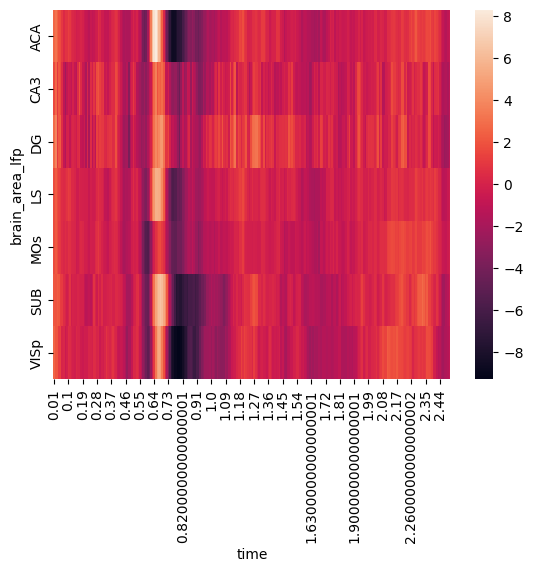

In [66]:
sns.heatmap(group)

We can select color map by specifying 'cmap'. There are many color maps to choose from like

'viridis'

'inferno'

'Greys'
 
etc


Plot a heatmap and set cmap='viridis'

<Axes: xlabel='time', ylabel='brain_area_lfp'>

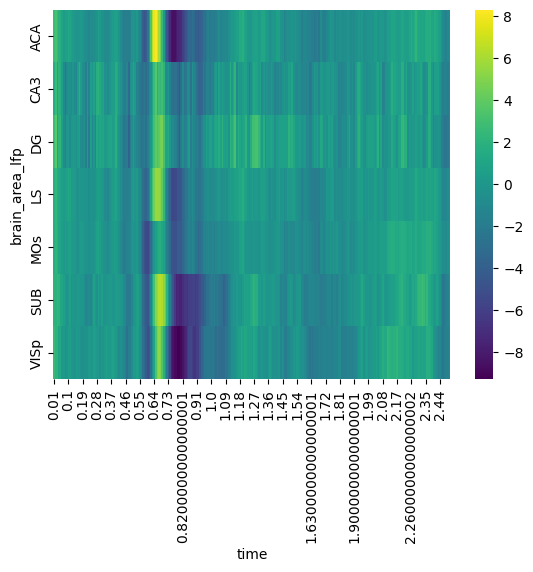

In [67]:
sns.heatmap(group, cmap='viridis')

We can set minimum and maximum values to anchor the colormap using vmin and vmax 

Set vmin=-6 and vmax=6

<Axes: xlabel='time', ylabel='brain_area_lfp'>

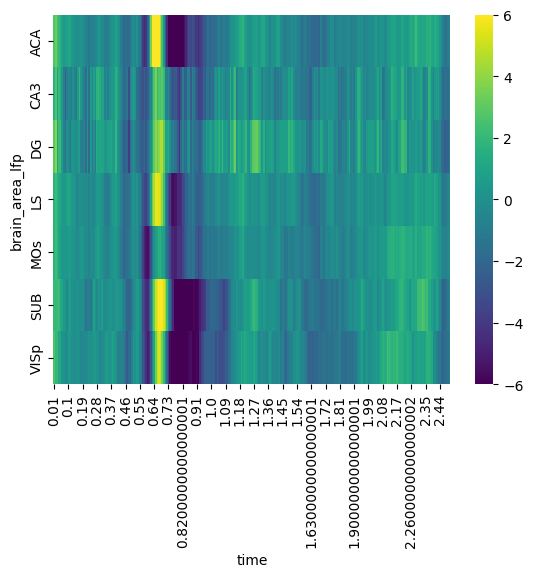

In [68]:
sns.heatmap(group, cmap='viridis', vmin=-6, vmax=6)

**Example** try plotting medians?

<Axes: xlabel='time', ylabel='brain_area_lfp'>

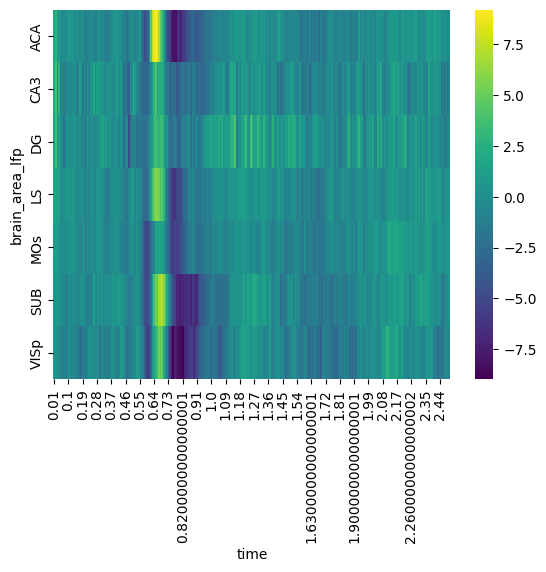

In [69]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].median().unstack()
sns.heatmap(group, cmap='viridis')

Try plotting minimum LFP values? 

<Axes: xlabel='time', ylabel='brain_area_lfp'>

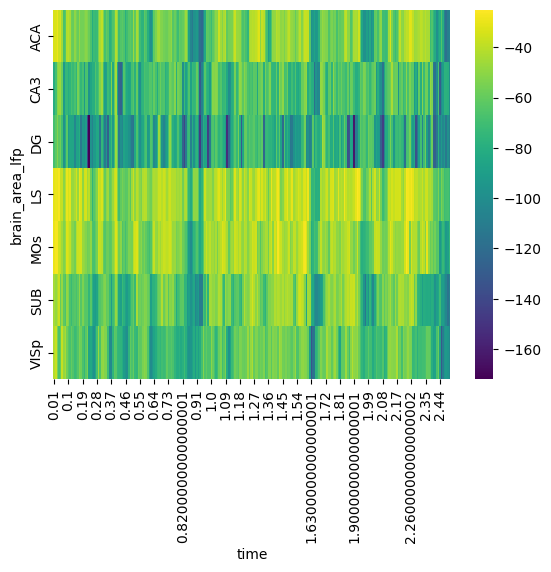

In [70]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].min().unstack()
sns.heatmap(group, cmap='viridis')

Try plotting maximum LFP values? 

<Axes: xlabel='time', ylabel='brain_area_lfp'>

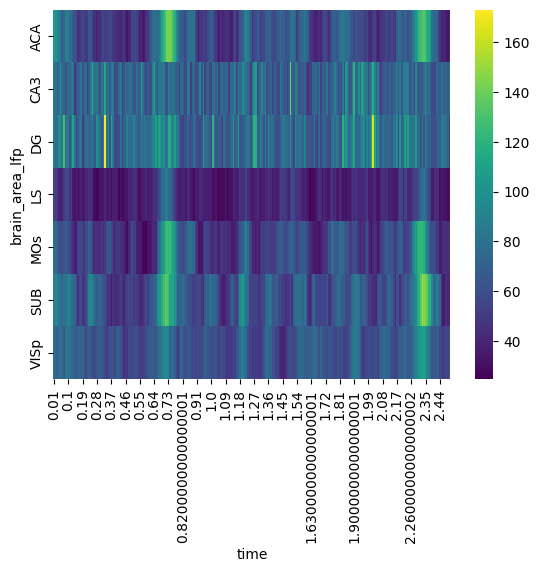

In [71]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].max().unstack()
sns.heatmap(group, cmap='viridis')